Seeing what I can do with stuff from here:

https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html#spectrogram

In [1]:
import math
from pathlib import Path
import sys

from IPython.display import Audio
import matplotlib.pyplot as plt
import torch
import torchaudio
from tqdm import tqdm

sys.path.append('../src')
from generate_waves import make_waveform

In [2]:
AUDIO_DIR = Path('../audio')

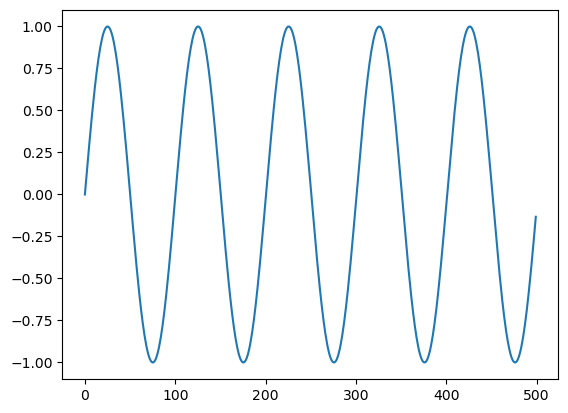

In [3]:
sine, _ = torchaudio.load(AUDIO_DIR / 'sine.wav')

plot_steps = 500
plt.plot(sine[0, :plot_steps])
plt.show()

Audio(AUDIO_DIR / 'sine.wav')

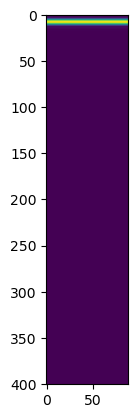

In [4]:
# define transformation
N_FFT = 800
WIN_LENGTH = 300
HOP_LENGTH = 500
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    win_length=WIN_LENGTH,
    hop_length=HOP_LENGTH,
    power=1.0,
)
# Perform transformation
spec = spectrogram(sine)

plt.imshow(spec[0])
plt.show()

# Make a saw wave at 440 Hz, analyse

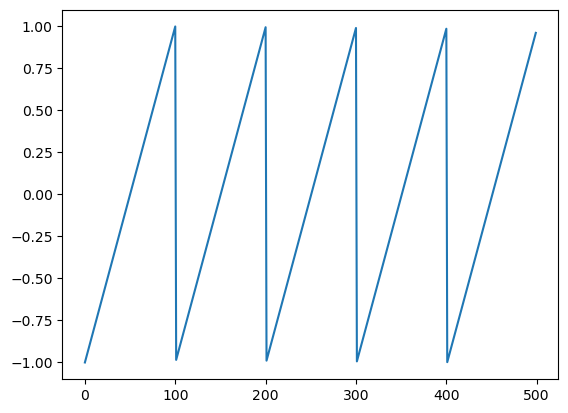

In [5]:
saw, _ = torchaudio.load(AUDIO_DIR / 'saw.wav')

plot_steps = 500
plt.plot(saw[0, :plot_steps])
plt.show()

Audio(AUDIO_DIR / 'saw.wav')

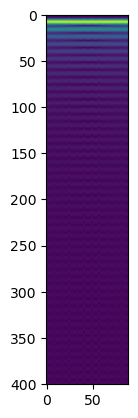

In [6]:
# Perform transformation
spec = spectrogram(saw)

plt.imshow(spec[0])
plt.show()

Work out frequencies of harmonics from vertical positions on the spectrogram

In [7]:
spec[0].shape

torch.Size([401, 89])

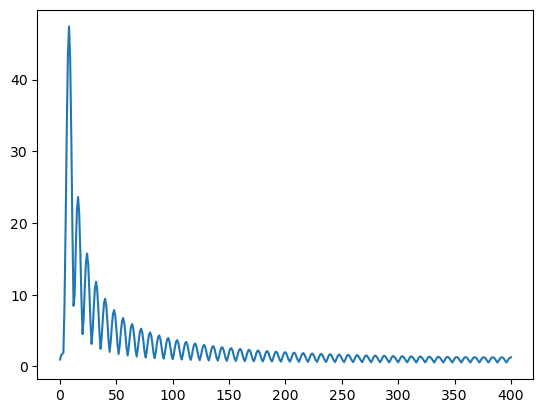

In [8]:
plt.plot(spec[0].mean(1))
plt.show()

## Stacked sines

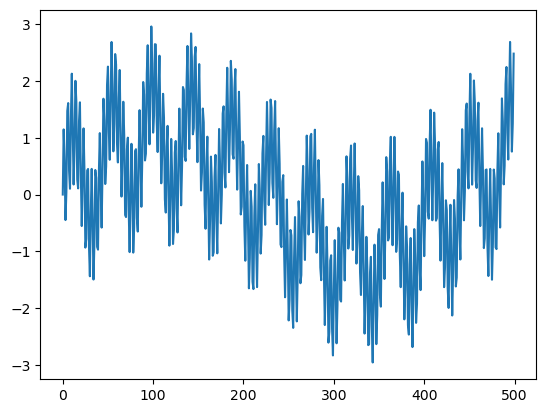

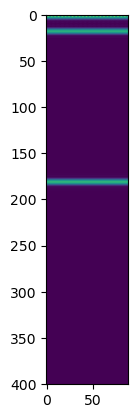

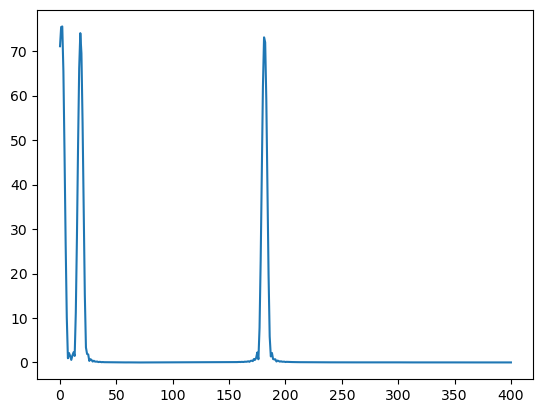

In [24]:
stacked_sines = make_waveform(100, torch.sin) + make_waveform(1000, torch.sin) + make_waveform(10000, torch.sin)

plot_steps = 500
plt.plot(stacked_sines[0, :plot_steps])
plt.show()

spec = spectrogram(stacked_sines)

plt.imshow(spec[0])
plt.show()

plt.plot(spec[0].mean(1))
plt.show()

In [221]:
def find_chunks(over_thresh):
    previous_val = -float("inf")
    current_chunk = []
    all_chunks = []
    for i, val in enumerate(over_thresh):
        if (val - previous_val > 1) and i > 0:
            all_chunks.append(current_chunk)
            current_chunk = []
        current_chunk.append(val.item())
        previous_val = val
    all_chunks.append(current_chunk)
    return all_chunks

def chunk_max(spec, chunk):
    return chunk[spec[0].mean(1)[chunk].argmax()]

def indices_over_threshold(spec, thresh):
    return (spec[0].mean(1) > thresh).nonzero().flatten()

def find_peaks(spec, thresh = 10):
    over_thresh = indices_over_threshold(spec, thresh)
    all_chunks = find_chunks(over_thresh)
    return [chunk_max(spec, chunk) for chunk in all_chunks]

find_peaks(spectrogram(stacked_sines))

[2, 18, 181]

In [66]:
N_FFT, WIN_LENGTH, HOP_LENGTH

(800, 300, 500)

In [90]:
# positions of peaks have stable vertical positions on the vertical axis, so we can work it out this way

# Is peak position just a function of pitch and n_fft? Looks like peak index = A * n_fft * freq
_spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=512,  # This moves the peaks (linearly related?)
    win_length=100,
    hop_length=100,
    power=1.0,
)
[
    find_peaks(_spectrogram(make_waveform(100, torch.sin))),
    find_peaks(_spectrogram(make_waveform(1000, torch.sin))),
    find_peaks(_spectrogram(make_waveform(10000, torch.sin))),
]

[[0], [12], [116]]

In [105]:
# Looks like the constant is: 2.265625e-05
freqs = [100 * 2 ** x for x in range(7)]
n_ffts = [100 * 2 ** x for x in range(7)]
for freq in freqs:
    for n_fft in n_ffts:
        _spectrogram = torchaudio.transforms.Spectrogram(
            n_fft=n_fft,  # This moves the peaks (linearly related?)
            win_length=100,
            hop_length=100,
            power=1.0,
        )
        peak = find_peaks(_spectrogram(make_waveform(freq, torch.sin)))[0]
        print(peak / (n_fft * freq))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.25e-06
6.25e-06
6.25e-06
6.25e-06
2.5e-05
2.5e-05
2.5e-05
2.1875e-05
2.1875e-05
2.265625e-05
2.2265625e-05
2.5e-05
2.5e-05
2.1875e-05
2.1875e-05
2.265625e-05
2.265625e-05
2.265625e-05
2.5e-05
2.1875e-05
2.34375e-05
2.265625e-05
2.265625e-05
2.265625e-05
2.265625e-05
2.1875e-05
2.34375e-05
2.265625e-05
2.265625e-05
2.265625e-05
2.265625e-05
2.265625e-05
2.34375e-05
2.265625e-05
2.265625e-05
2.265625e-05
2.265625e-05
2.265625e-05
2.26806640625e-05


# Testing out my interpretation of the dimensions of the spectrogram

In [115]:
def n_rows(n_fft):
    return int(n_fft / 2 + 1)

def n_cols(waveform, hop_length):
    """
    Sometimes off by 1
    """
    return math.floor(waveform.shape[1] / hop_length + 1)

def freq_to_index(n_fft, freq):
    CONST = 2.265625e-05
    return int(CONST * n_fft * freq)

In [240]:
N_TEST = 100

dimension_check_results = []
index_check_results = []

for _ in tqdm(range(N_TEST)):
    while True:
        n_fft, win_length, hop_length = (int(x) for x in torch.randint(1000, (3,)))
        freq = torch.randint(20, 20000, (1,)).item()
        if 0 < win_length <= n_fft:
            break
    _spectrogram = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        power=1.0,
    )

    spec = _spectrogram(make_waveform(freq, torch.sin))

    # Spectrogram output dimensions as expected
    dimension_check_results.append(
        spec.shape == (1, n_rows(n_fft), n_cols(saw, hop_length))
    )
    # Peak at expected index
    index_check_results.append(
        find_peaks(spec, thresh=spec[0].mean(1).max().item() * 0.5)[0] == freq_to_index(n_fft, freq)
    )
 
print('dimension results:', torch.tensor(dimension_check_results, dtype=float).mean().item())
print('index results:', torch.tensor(index_check_results, dtype=float).mean().item())

100%|██████████| 100/100 [00:00<00:00, 290.38it/s]

dimension results: 0.98
index results: 0.33


In [196]:
n_fft, win_length, hop_length, freq

(618, 188, 847, 17414)